In [30]:
import joblib
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from cleaning_data import clean_text_vietnamese
from __future__ import print_function
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.animation import FuncAnimation, PillowWriter
np.random.seed(17)

In [58]:
#Hàm vẽ các điểm dữ liệu
def draw_datapoints(X0,X1):
    plt.scatter(X0[:, 0], X0[:, 1], c='b', label='Class y = 1')  # Class +1 points
    plt.scatter(X1[:, 0], X1[:, 1], c='r', label='Class y = -1')  # Class -1 points
    plt.xlim(-25,25)
    plt.ylim(-25,25)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend()
    plt.grid(True)
    plt.show()

In [59]:
'''Mô hình giải bài toán linear SVM bằng thuật toán SMO, trong đó:
    + self.X, self.y lần lượt là các điểm dữ liệu train và nhãn tương ứng
    + self.C là giá trị hằng số tradeoff trong soft margin SVM
    + self.w, self.b là giá trị vector pháp tuyến và hằng số tự do trong phương trình siêu phẳng cần tìm
    + self.max_iter là số vòng lặp tối đa khi huân luyện mô hình
    + method .fit() huấn luyện mô hình và trả về hai mảng self.hyperplane_changes,self.alphas_changes thể hiện sự biến thiên giá trị
    các tham số của phương trình siêu phẳng và vector nhân tử Lagrange khi huận luyện mô hình'''
class SVM:
    def __init__(self, X, y, C=10^5, b=0, max_iter=300, tol=1e-5, eps=1e-8):
        self.X = X
        self.y = y
        self.m, self.n = np.shape(self.X)
        self.C = C
        self.alphas = np.zeros(self.m)
        self.b = b
        self.hyperplane_changes=[]
        self.alphas_changes=[]
        self.kernel_func = self.linear_kernel
        self.error = np.zeros(self.m)
        self.max_iter=max_iter
        self.tol = tol
        self.eps = eps
        self.w = np.zeros(self.n)
    def linear_kernel(self, x1, x2, b=0):
        return x1 @ x2.T + b
    def predict(self, x):
        result = (self.alphas * self.y) @ self.kernel_func(self.X, x) + self.b
        return result
    def get_error(self, i):
        return self.predict(self.X[i,:]) - self.y[i]
    def take_step(self, i1, i2):
        if (i1 == i2):
            return 0
        x1 = self.X[i1, :]
        x2 = self.X[i2, :]
        y1 = self.y[i1]
        y2 = self.y[i2]
        alpha1 = self.alphas[i1]
        alpha2 = self.alphas[i2]
        b = self.b
        E1 = self.get_error(i1)
        E2 = self.get_error(i2)
        s = y1 * y2
        if y1 != y2:
            L = max(0, alpha2 - alpha1)
            H = min(self.C, self.C + alpha2 - alpha1)
        else:
            L = max(0, alpha2 + alpha1 - self.C)
            H = min(self.C, alpha2 + alpha1)
        if L == H:
            return 0
        k11 = self.kernel_func(x1, x1)
        k12 = self.kernel_func(x1, x2)
        k22 = self.kernel_func(x2, x2)
        eta = k11 + k22 - 2 * k12
        if eta > 0:
            alpha2_new = alpha2 + y2 * (E1 - E2) / eta
            if alpha2_new >= H:
                alpha2_new = H
            elif alpha2_new <= L:
                alpha2_new = L
        else:
            return 0
        if abs(alpha2_new - alpha2) < self.eps * (alpha2 + alpha2_new + self.eps):
            return 0
        alpha1_new = alpha1 + s * (alpha2 - alpha2_new)
        if alpha1_new < self.eps:
            alpha1_new = 0
        elif alpha1_new > (self.C - self.eps):
            alpha1_new = self.C
        b1 = b - E1 - y1 * (alpha1_new - alpha1) * k11 - y2 * (alpha2_new - alpha2) * k12
        b2 = b - E2 - y1 * (alpha1_new - alpha1) * k12 - y2 * (alpha2_new - alpha2) * k22
        if 0 < alpha1_new < self.C:
            self.b = b1
        elif 0 < alpha2_new < self.C:
            self.b = b2
        else:
            self.b = 0.5 * (b1 + b2)
        self.w = self.w + y1 * (alpha1_new - alpha1) * x1 + y2 * (alpha2_new - alpha2) * x2
        self.hyperplane_changes.append([self.w.copy(),self.b])
        self.alphas[i1] = alpha1_new
        self.alphas[i2] = alpha2_new
        self.alphas_changes.append(self.alphas.copy())
        self.error[i1] = 0
        self.error[i2] = 0
        i_list = [idx for idx, alpha in enumerate(self.alphas) if 0 < alpha and alpha < self.C]
        for i in i_list:
            self.error[i] += y1 * (alpha1_new - alpha1) * self.kernel_func(x1, self.X[i,:]) + y2 * (alpha2_new - alpha2) * self.kernel_func(x2, self.X[i,:]) + (self.b - b)
        return 1
    def examine_example(self, i2):
        y2 = self.y[i2]
        alpha2 = self.alphas[i2]
        E2 = self.get_error(i2)
        r2 = E2 * y2
        if ((r2 < -self.tol and alpha2 < self.C) or (r2 > self.tol and alpha2 > 0)):
            if len(self.alphas[(0 < self.alphas) & (self.alphas < self.C)]) > 1:
                if E2 > 0:
                    i1 = np.argmin(self.error)
                else:
                    i1 = np.argmax(self.error)

                if self.take_step(i1, i2):
                    return 1

            i1_list = [idx for idx, alpha in enumerate(self.alphas) if 0 < alpha and alpha < self.C]
            i1_list = np.roll(i1_list, np.random.choice(np.arange(self.m)))
            for i1 in i1_list:
                if self.take_step(i1, i2):
                    return 1
            i1_list = np.roll(np.arange(self.m), np.random.choice(np.arange(self.m)))
            for i1 in i1_list:
                if self.take_step(i1, i2):
                    return 1
        return 0
    def fit(self):
        loop_num = 0
        numChanged = 0
        examineAll = True
        while numChanged > 0 or examineAll:
            if loop_num >= self.max_iter:
                break
            numChanged = 0
            if examineAll:
                for i2 in range(self.m):
                    numChanged += self.examine_example(i2)
            else:
                i2_list = [idx for idx, alpha in enumerate(self.alphas) if 0 < alpha and alpha < self.C]
                for i2 in i2_list:
                    numChanged += self.examine_example(i2)
            if examineAll:
                examineAll = False
            elif numChanged == 0:
                examineAll = True
            loop_num += 1
        return self.hyperplane_changes,self.alphas_changes

In [60]:
#Hàm tính toán giá trị của hàm đối ngẫu
def compute_dual_objective(lambda_vals, y, X):
    m = len(lambda_vals)
    term1 = np.sum(lambda_vals)
    term2 = 0
    for i in range(m):
        for j in range(m):
            term2 += lambda_vals[i] * lambda_vals[j] * y[i] * y[j] * np.dot(X[i], X[j])
    g_lambda = term1 - 0.5 * term2
    return g_lambda

In [61]:
'''Hàm trực quan hóa siêu phẳng mà mô hình linear SVM tìm được
và sự biến thiên giá trị của hàm đối ngẫu qua mỗi lần cập nhật vector nhân tử Lagrange trong SMO'''
def draw_model(X,Y,X0,X1,C):
    #Mô hình giải tìm siêu phẳng tối ưu
    scaler = StandardScaler()
    train_x = scaler.fit_transform(X)
    model = SVM(train_x, Y, C=C, max_iter=600, tol=1e-5, eps=1e-5)
    hyperplane,alphas=model.fit()
    train_y = model.predict(train_x)
    #Duyệt qua các nhân tử Lagrange để tìm suppport vectors, in chúng và giá trị các tham số của mô hình.
    print('support vector: {} / {}'.format(len(model.alphas[model.alphas != 0]), len(model.alphas)))
    sv_idx = []
    for idx, alpha in enumerate(model.alphas):
        if alpha != 0:
            print('index = {}, alpha = {:.3f}, predict y={:.3f}'.format(idx, alpha, train_y[idx]))
            sv_idx.append(idx)
    print('w={}'.format(model.w))
    print(f'bias = {model.b}')
    print('training data error rate = {}'.format(len(Y[Y * train_y < 0])/len(Y)))
    #Vẽ các điểm dữ liệu thuộc 2 lớp trong tập train, support vectors và siêu phẳng tối ưu
    plt.scatter(X0[:, 0], X0[:, 1], c='b', label='Class y = 1')
    plt.scatter(X1[:, 0], X1[:, 1], c='r', label='Class y = -1')
    plt.grid(True)
    resolution = 50
    dx = np.linspace(X[:, 0].min(), X[:, 0].max(), resolution)
    dy = np.linspace(X[:, 1].min(), X[:, 1].max(), resolution)
    dx, dy = np.meshgrid(dx, dy)
    plot_x = np.c_[dx.flatten(), dy.flatten()]
    dz = model.predict(scaler.transform(plot_x))
    dz = dz.reshape(dx.shape)
    plt.contourf(dx, dy, dz, alpha=0.4, levels=[-36, 0, 36], colors=['lightcoral', 'lightblue'])
    plt.contour(dx, dy, dz, alpha=1, colors=('k', 'k', 'k'),levels=(-1, 0, 1), linestyles = ('--', '-', '--'))
    label_cnt = 0
    label_cnt = 0
    for i in sv_idx:
        if label_cnt == 0:
            plt.scatter(X[i, 0], X[i, 1], facecolors='none',edgecolors='g',s=100, label='Support vector')
            label_cnt += 1
            continue
        plt.scatter(X[i, 0], X[i, 1], facecolors='none',edgecolors='g',s=100,)
    plt.legend()
    plt.show()
    #Đoạn code thể hiện sự biến thiên của hàm đối ngẫu g(lamda) qua mỗi vòng lặp của thuật toán SMO
    function_values = [compute_dual_objective(alpha, Y, train_x) for alpha in alphas]

    fig, ax = plt.subplots()
    ax.set_xlim(0, len(alphas) + 1)
    ax.set_ylim(min(function_values) - 1, max(function_values) + 1)
    ax.set_xlabel('Iteration')
    ax.set_ylabel(r'$g(\boldsymbol{\lambda})$')
    ax.set_title('Dual Objective Function Value over Iterations')
    ax.plot(range(1, len(alphas) + 1), function_values, 'o-', lw=2, markersize=3)
    plt.show()
    '''#Đoạn code sau lưu file.gif thể hiện sự biến thiên giá trị của hàm đối ngẫu vào thiết bị
    fig, ax = plt.subplots()
    ax.set_xlim(0, len(alphas) + 1)
    ax.set_ylim(min(function_values) - 1, max(function_values) + 1)
    ax.set_xlabel('Iteration')
    ax.set_ylabel(r'$g(\boldsymbol{\lambda})$')
    ax.set_title('Dual Objective Function Value over Iterations')

    line, = ax.plot([], [], 'o-', lw=2, markersize=3)

    def update(frame):
        line.set_data(range(1, frame + 2), function_values[:frame + 1])
        return line,

    anim = FuncAnimation(fig, update, frames=len(alphas), interval=100, blit=True)

    # Save as GIF
    anim.save('dual_objective.gif', writer=PillowWriter(fps=10))'''

<>:54: SyntaxWarning: invalid escape sequence '\l'
<>:54: SyntaxWarning: invalid escape sequence '\l'
C:\Users\ASUS\AppData\Local\Temp\ipykernel_33056\904569167.py:54: SyntaxWarning: invalid escape sequence '\l'
  '''#Đoạn code sau lưu file.gif thể hiện sự biến thiên giá trị của hàm đối ngẫu vào thiết bị


In [62]:
#Tạo train dataset có thể phân chia một cách tuyến tính cho hard margin svm
means = [[10,10], [-10,-10]]
cov = [[25, .2], [.2, 25]]
N = 36
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X = np.concatenate((X0.T, X1.T), axis = 1).T
Y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)[0]

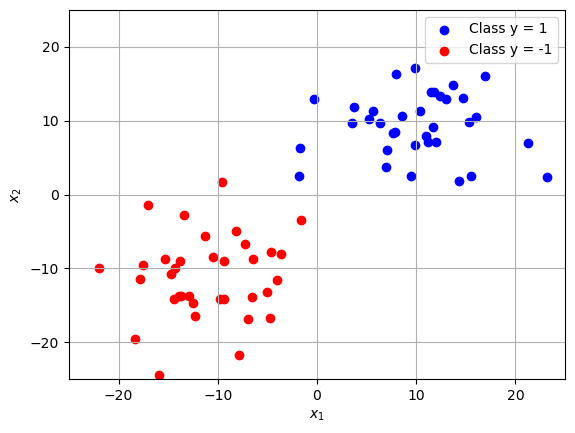

In [63]:
draw_datapoints(X0,X1)

support vector: 3 / 72
index = 34, alpha = 11.983, predict y=1.000
index = 60, alpha = 7.917, predict y=-1.000
index = 71, alpha = 4.066, predict y=-1.000
w=[2.60987333 4.14188998]
bias = 0.13369278698741172
training data error rate = 0.0


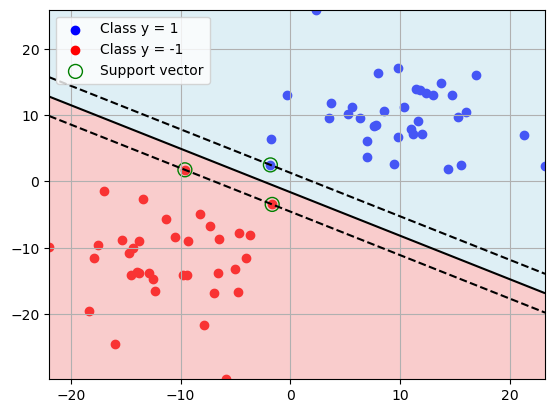

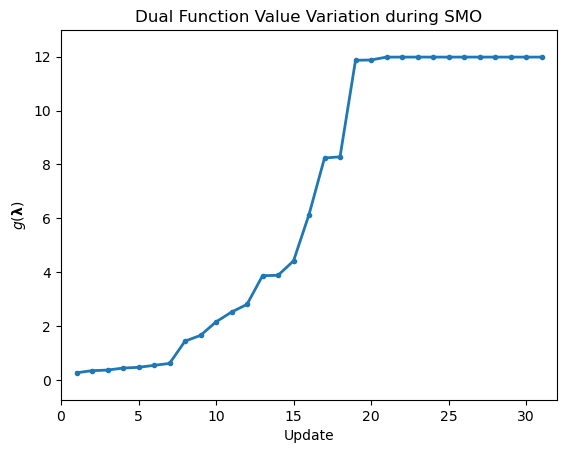

In [64]:
draw_model(X,Y,X0,X1,100000)

In [65]:
#Tạo train dataset không thể phân chia 1 cách tuyến tính cho soft margin SVM
means = [[10,10], [-10,-10]]
cov = [[90, .2], [.2, 90]]
N = 36
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X = np.concatenate((X0.T, X1.T), axis = 1).T
Y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)[0]

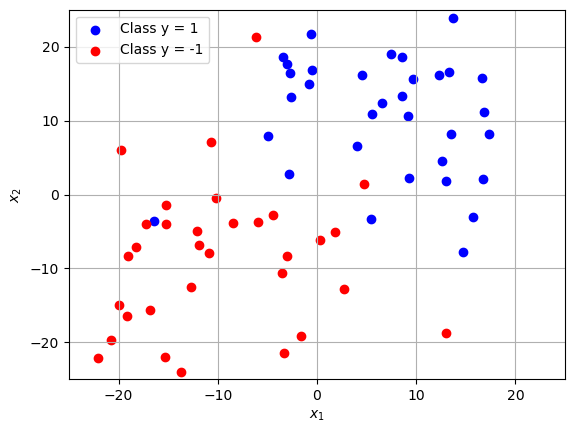

In [66]:
draw_datapoints(X0,X1)

support vector: 17 / 72
index = 6, alpha = 1.000, predict y=-1.929
index = 7, alpha = 1.000, predict y=0.437
index = 8, alpha = 1.000, predict y=0.056
index = 10, alpha = 0.140, predict y=1.000
index = 11, alpha = 1.000, predict y=0.922
index = 15, alpha = 0.753, predict y=1.000
index = 18, alpha = 1.000, predict y=0.955
index = 24, alpha = 1.000, predict y=0.254
index = 33, alpha = 1.000, predict y=-0.082
index = 37, alpha = 1.000, predict y=-0.778
index = 38, alpha = 1.000, predict y=-0.819
index = 39, alpha = 1.000, predict y=-0.333
index = 41, alpha = 1.000, predict y=0.467
index = 49, alpha = 1.000, predict y=-0.445
index = 51, alpha = 1.000, predict y=-0.700
index = 56, alpha = 0.893, predict y=-1.000
index = 63, alpha = 1.000, predict y=1.490
w=[1.20677145 1.43608487]
bias = -0.18348336807974297
training data error rate = 0.05555555555555555


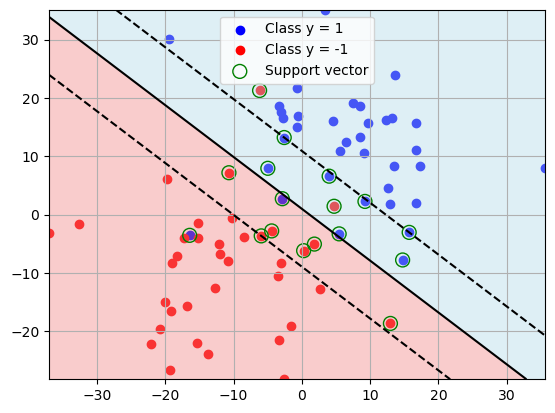

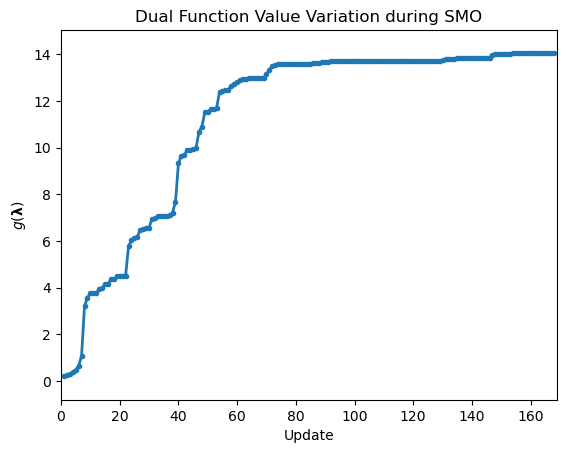

In [67]:
draw_model(X,Y,X0,X1,1)

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

# Generate synthetic data
X, y = make_classification(
    n_samples=10000, n_features=3, n_informative=2, n_redundant=0,
    n_clusters_per_class=1, class_sep=1.0, random_state=42
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Different values of C
C_values = [0.0001,0.001,0.01,0.1,1,10,100,10000]
results = []

for C in C_values:
    # Train SVM
    model = SVC(C=C, kernel='linear')
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate margin width
    w = model.coef_[0]
    margin = 2 / np.linalg.norm(w)

    results.append((C, accuracy, margin))

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results, columns=["C", "Accuracy", "Margin Width"])
print(results_df)


            C  Accuracy  Margin Width
0      0.0001     0.841      3.651250
1      0.0010     0.966      1.606032
2      0.0100     0.976      0.853860
3      0.1000     0.977      0.555386
4      1.0000     0.977      0.476965
5     10.0000     0.977      0.464670
6    100.0000     0.977      0.464598
7  10000.0000     0.977      0.466252


# Demo Polynomial Kernel

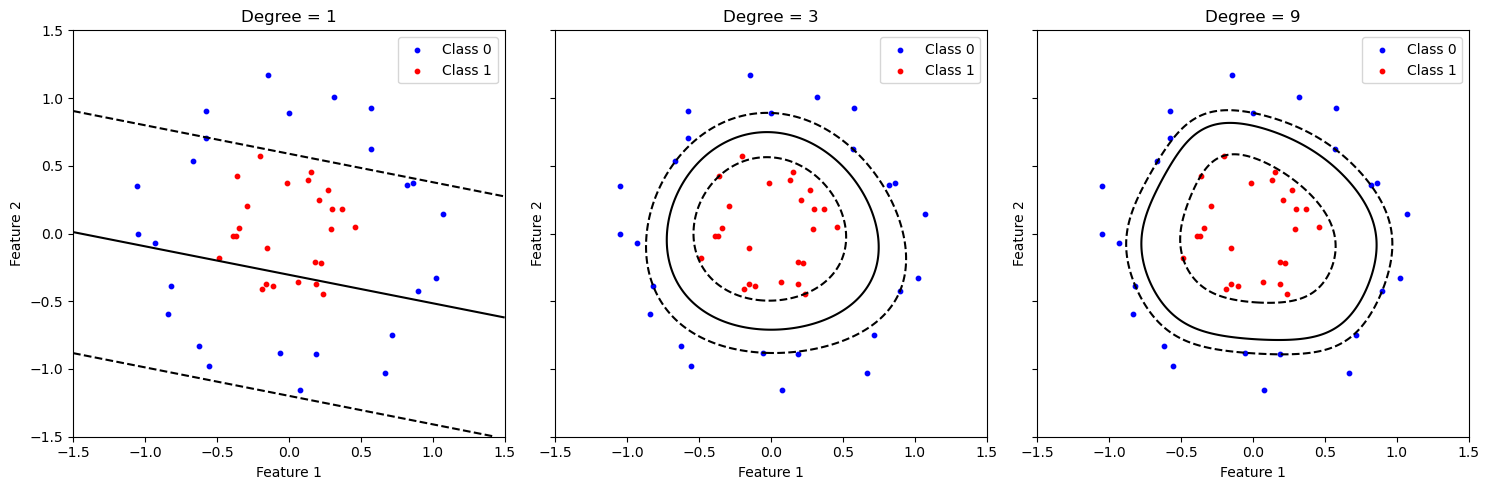

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Generate circular dataset
X, y = make_circles(n_samples=50, factor=0.4, noise=0.1, random_state=23520123)

# Function to plot decision boundaries with contour lines
def plot_decision_boundaries(clf, X, y, ax, title):
    # Create a mesh grid for plotting
    xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 500), np.linspace(-1.5, 1.5, 500))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot contour lines for the decision function
    ax.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='black')
    # Scatter plot for points, blue for class 0, red for class 1
    ax.scatter(X[y == 0, 0], X[y == 0, 1], color='blue', label='Class 0',s= 10)
    ax.scatter(X[y == 1, 0], X[y == 1, 1], color='red', label='Class 1',s = 10)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend(loc='upper right')

# Degrees of polynomial kernel to plot
degrees = [1, 3, 9]

# Plotting decision boundaries for different polynomial kernel degrees
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, degree in enumerate(degrees):
    # Create a pipeline with scaling and SVM
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='poly', degree=degree, coef0=1, C=1))
    ])
    clf.fit(X, y)
    
    # Plot the decision boundary
    plot_decision_boundaries(clf, X, y, axes[i], title=f"Degree = {degree}")

plt.tight_layout()
plt.show()


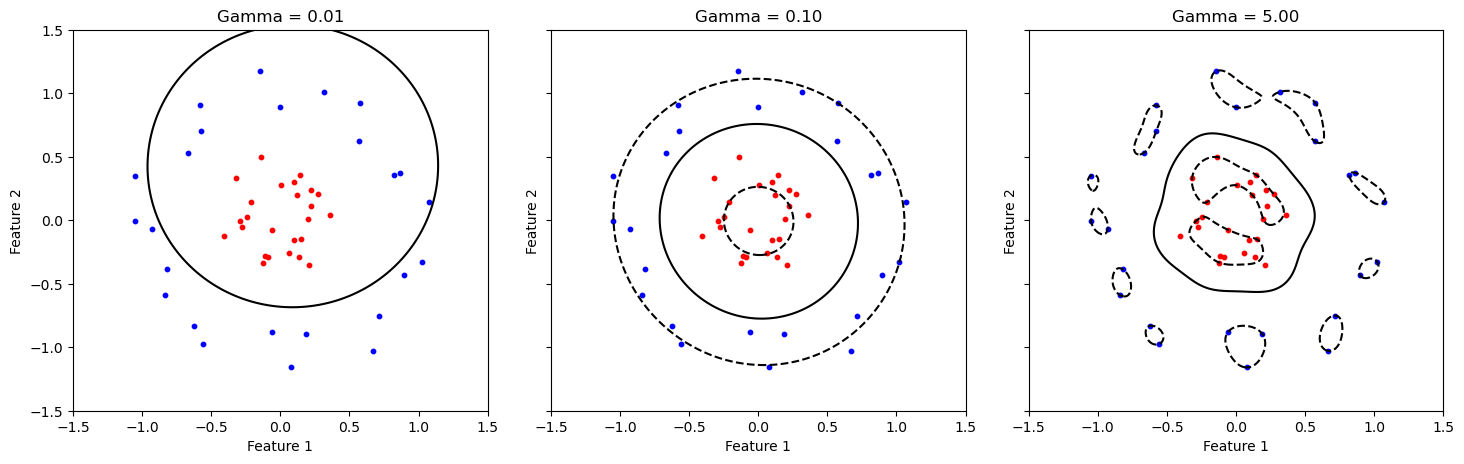

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Generate circular dataset
X, y = make_circles(n_samples=50, factor=0.3, noise=0.1, random_state=23520123)

# Function to plot decision boundaries with RBF kernel
def plot_rbf_gamma(gamma, ax):
    # Create and fit the SVM model with RBF kernel
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', gamma=gamma, C=1))
    ])
    clf.fit(X, y)
    
    # Create a mesh grid for decision boundary
    xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 500), np.linspace(-1.5, 1.5, 500))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    ax.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='black')
    ax.scatter(X[y == 0, 0], X[y == 0, 1], color='blue', label='Class 0',s= 10)
    ax.scatter(X[y == 1, 0], X[y == 1, 1], color='red', label='Class 1',s = 10)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_title(f"Gamma = {gamma:.2f}", fontsize=12)
    ax.set_xlabel("Feature 1", fontsize=10)
    ax.set_ylabel("Feature 2", fontsize=10)

# Gamma values to plot
gammas = [0.01, 0.1, 5.0]

# Create subplots for different gamma values
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)  # Adjusted figsize for better fit

for i, gamma in enumerate(gammas):
    plot_rbf_gamma(gamma, axes[i])

plt.tight_layout(pad=2)  # Add slight padding for spacing
plt.show()


# Classify customer comments and emotions
Problem: Classify Vietnamese customer comments by predicting whether the comments are positive or negative.

# Loading Phobert model

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
bert_model = AutoModel.from_pretrained("vinai/phobert-base").to(device)

# Get bert embedding from sentence

In [70]:
def get_bert_embedding(sentence):
    sentence = clean_text_vietnamese(sentence, keep_punct=True)
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=128)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    with torch.no_grad():
        outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state
    sentence_embedding = embeddings.mean(dim=1).squeeze().cpu().numpy()
    return sentence_embedding

# Evaluate the accurate of model

In [51]:
def evaluate_model(test_file,svm_model):
    # Load test data
    test_data = pd.read_excel(test_file)
    
    # Ensure column names are lowercase
    test_data.columns = test_data.columns.str.lower()
    # Get predictions using lowercase column names
    X_test = [get_bert_embedding(text) for text in test_data['text']]
    y_true = test_data['label']
    y_pred = svm_model.predict(X_test)
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    print(f"\nAccuracy: {accuracy:.6f}")
    print("\nDetailed Classification Report:")
    print(report)
    
    return accuracy, report

# Loading the pre-trained model

In [52]:
model_path_poly = 'svm_model_poly.pkl'
model_path_linear = 'svm_model_linear.pkl'
model_path_rbf = 'svm_model_rbf.pkl'
model_path_logistic_regression = 'model_logistic.pkl'
model_path = {
    "Linear SVM": model_path_linear,
    "Polynomial SVM": model_path_poly,
    "RBF SVM": model_path_rbf,
    "Logistic Regression": model_path_logistic_regression
}

In [53]:
results = []
for model_name, model_file in model_path.items():
    model = joblib.load(model_file)
    test_file = "Testing_dataset.xlsx"
    print(f"Evaluating {model_name}:")
    accuracy, report = evaluate_model(test_file, model)
    results.append({
        'Model Name': model_name,
        'Model Type': "SVM" if "SVM" in model_name else "Logistic Regression",
        'Accuracy (%)': f"{accuracy * 100:.4f}"
    })
    print("\n")

Evaluating Linear SVM:

Accuracy: 0.980490

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       585
           1       0.99      0.98      0.99      1414

    accuracy                           0.98      1999
   macro avg       0.97      0.98      0.98      1999
weighted avg       0.98      0.98      0.98      1999



Evaluating Polynomial SVM:

Accuracy: 0.982991

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       585
           1       1.00      0.98      0.99      1414

    accuracy                           0.98      1999
   macro avg       0.97      0.98      0.98      1999
weighted avg       0.98      0.98      0.98      1999



Evaluating RBF SVM:

Accuracy: 0.983492

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       585
    

In [50]:
comparison_df = pd.DataFrame(results)

# Display a pretty table using tabulate
print("\nModel Comparison Table:")
print(tabulate(comparison_df, headers='keys', tablefmt='fancy_grid'))


Model Comparison Table:
╒════╤═════════════════════╤═════════════════════╤════════════════╕
│    │ Model Name          │ Model Type          │   Accuracy (%) │
╞════╪═════════════════════╪═════════════════════╪════════════════╡
│  0 │ Linear SVM          │ SVM                 │        98.049  │
├────┼─────────────────────┼─────────────────────┼────────────────┤
│  1 │ Polynomial SVM      │ SVM                 │        98.2991 │
├────┼─────────────────────┼─────────────────────┼────────────────┤
│  2 │ RBF SVM             │ SVM                 │        98.3492 │
├────┼─────────────────────┼─────────────────────┼────────────────┤
│  3 │ Logistic Regression │ Logistic Regression │        98.1491 │
╘════╧═════════════════════╧═════════════════════╧════════════════╛


# Using RBF kernel for demo

In [38]:
svm_model = joblib.load('svm_model_rbf.pkl')

In [40]:
while True:
    input_text = input("Nhập câu để kiểm tra cảm xúc (hoặc nhập 'q' để thoát): ")
    if input_text == 'q':
            break
    sentence_embedding = get_bert_embedding(input_text)
    predicted_sentiment = svm_model.predict([sentence_embedding])[0]  # Dự đoán 1 câu
    print(input_text)
    if predicted_sentiment == 0:
            print("Cảm xúc: Tiêu cực")
    else:    
            print("Cảm xúc: Tích cực")

sản phẩm này tệ thế
Cảm xúc: Tiêu cực
sản phẩm này không tệ
Cảm xúc: Tích cực
sản phẩm này dùng đã thật, tôi rất thích nó
Cảm xúc: Tích cực
nếu biết trước công dụng của nó tuyệt vời đến vậy tôi đã mua từ lâu
Cảm xúc: Tích cực
sản phẩm này dùng rất tệ, dùng được có vài ngày đã hư lên hư xuống, thật đáng thất vọng
Cảm xúc: Tiêu cực
sản phẩm này không tốt
Cảm xúc: Tiêu cực
sản phẩm này tốt
Cảm xúc: Tích cực
